## prework

* import basic dependencies
* load data [keras.datasets mnist]
* check data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-numpy/mnist.npz


In [2]:
# import basic dependencies
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# load data from keras.datasets
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train.shape, _.shape, x_test.shape, _.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000,), (10000, 28, 28), (10000,))

## Data preprocessing and data

* normalization
* two kinds of data preprocessing
    * reshape => flatten to vector
    * reshape to images shape [three dim] 
* data augmentatioin - add gauss noise

In [4]:
# normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# reshape => flatten
autoencoder_x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
autoencoder_x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder_x_train.shape, autoencoder_x_test.shape

((60000, 784), (10000, 784))

In [6]:
# cnn_autoencoder => reshape to image shape
cnn_autoencoder_x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
cnn_autoencoder_x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
cnn_autoencoder_x_train.shape, cnn_autoencoder_x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### augmentation

In [7]:
# add gauss noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_train_noisy.shape, x_test_noisy.shape

((60000, 28, 28), (10000, 28, 28))

## Model -- Basic AutoEncoder

* hyper-parameters
* import keras dependencies
* build auto-encoder model
* build saparate model
    * extract encoder
    * extract decoder
    * build decoder model
    * compile, summary
* combine to validate, predict
* plot for check


In [8]:
# hyper-parameters
encoding_dim = 32
epochs = 50
batch_size=256

In [9]:
from keras.models import Model
from keras.layers import Input, Dense

In [10]:
# build encoder
input_img = Input(shape=(784, ), name='autoencoder_input')
encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_img) # encode
decoded = Dense(784, activation='sigmoid', name='decoder')(encoded) # decode
autoencoder = Model(inputs=input_img, outputs=decoded)

In [11]:
# compile and summary
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit (input and output => x_train)
autoencoder.fit(
    autoencoder_x_train, autoencoder_x_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True, 
    validation_data=(autoencoder_x_test, autoencoder_x_test)
)

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6919 - val_loss: 0.6918

In [13]:
# extract encoder
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(encoding_dim, ))
# extract decoder
decoder_layer = autoencoder.layers[-1]

decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [14]:
encoded_imgs = encoder.predict(autoencoder_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

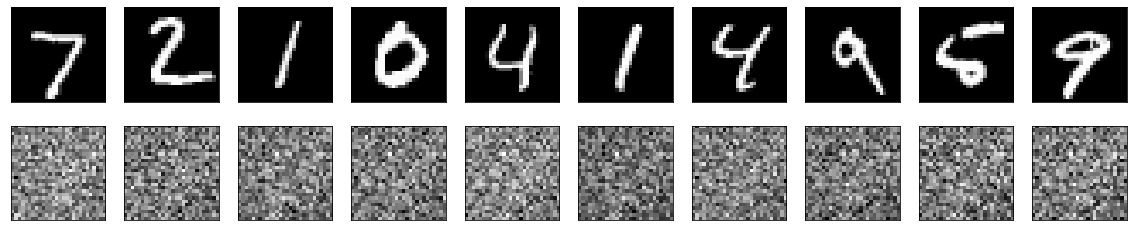

In [15]:
# plot
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # show origin images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(autoencoder_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # show autoencoded images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model -- Advanced CNN AutoEncoder


* import keras dependencies
* build auto-encoder model
* build saparate model
    * extract encoder
    * extract decoder
    * build decoder model
    * compile, summary
* combine to validate, predict
* plot for check


In [16]:
# cnn_autoencoder hyper-parameters
epochs = 50
batch_size = 128

In [17]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

In [18]:
# build model
input_img = Input(shape=(28, 28, 1), name='cnn_autoencoder_input')
# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='encoder_maxpooling1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='encoder_maxpooling2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
cnn_encoded = MaxPooling2D((2, 2), padding='same', name='encoder_output')(x)
# decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(cnn_encoded)
x = UpSampling2D((2, 2), name='decoder_upsampling1')(x)#上采样层
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
x = UpSampling2D((2, 2), name='decoder_upsampling2')(x)
x = Conv2D(16, (3, 3), activation='relu', name='decoder_conv3')(x)
x = UpSampling2D((2, 2), name='decoder_upsampling3')(x)
cnn_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
cnn_autoencoder = Model(input_img, cnn_decoded)

In [19]:
# compile and summary
cnn_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
cnn_autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_autoencoder_input (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder_maxpooling1 (MaxPool (None, 14, 14, 16)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 8)         1160      
_________________________________________________________________
encoder_maxpooling2 (MaxPool (None, 7, 7, 8)           0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 7, 7, 8)           584       
_________________________________________________________________
encoder_output (MaxPooling2D (None, 4, 4, 8)          

In [20]:
# fit
cnn_autoencoder.fit(
    cnn_autoencoder_x_train, cnn_autoencoder_x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(cnn_autoencoder_x_test, cnn_autoencoder_x_test),
)

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.6873 - val_loss: 0.6845
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6803 - val_loss: 0.6757
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6681 - val_loss: 0.6590
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6406 - val_loss: 0.6157
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.5663 - val_loss: 0.5154
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.4914 - val_loss: 0.4861
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.4792 - val_loss: 0.4799
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.4733 - val_loss: 0.4743
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.4680 - val_loss: 0.4690
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.4629 - val_loss: 0.4641

In [21]:
# predict
cnn_decoded_imgs = cnn_autoencoder.predict(cnn_autoencoder_x_test)

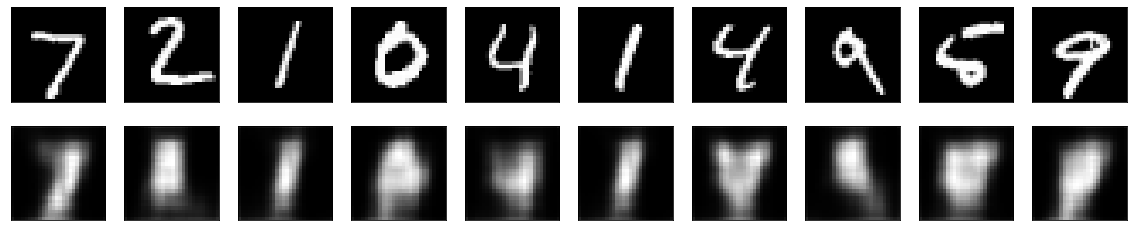

In [22]:
# plot
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # show origin images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(cnn_autoencoder_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # show autoencoded images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(cnn_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model - CNN AutoEncoder(With Data Augmentation)


* import keras dependencies
* build auto-encoder model
* build saparate model
    * extract encoder
    * extract decoder
    * build decoder model
    * compile, summary
* combine to validate, predict
* plot for check


In [23]:
# hyper-parameter
epochs = 100
batch_size = 128

In [24]:
# build model
input_img = Input(shape=(28, 28, 1), name='cnn_autoencoder_input') 
# encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='encoder_maxpooling1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
cnn_encoded = MaxPooling2D((2, 2), padding='same', name='encoder_maxpooling2')(x)
# decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv1')(cnn_encoded)
x = UpSampling2D((2, 2), name='decoder_upsampling1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
x = UpSampling2D((2, 2), name='decoder_upsampling2')(x)
cnn_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
# autoencoder
cnn_autoencoder = Model(input_img, cnn_decoded)

In [25]:
# compile and summary
cnn_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
cnn_autoencoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_autoencoder_input (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_maxpooling1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 32)        9248      
_________________________________________________________________
encoder_maxpooling2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
decoder_conv1 (Conv2D)       (None, 7, 7, 32)          9248      
_________________________________________________________________
decoder_upsampling1 (UpSampl (None, 14, 14, 32)       

In [26]:
# fit
cnn_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6740 - val_loss: 0.6626
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.6393 - val_loss: 0.6099
Epoch 3/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5691 - val_loss: 0.5345
Epoch 4/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5164 - val_loss: 0.5117
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5042 - val_loss: 0.5042
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.4968 - val_loss: 0.4967
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4891 - val_loss: 0.4889
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4814 - val_loss: 0.4811
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4735 - val_loss: 0.4728
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4650 - val_lo

In [27]:
# predict
noisy_decoded_imgs = cnn_autoencoder.predict(x_test)

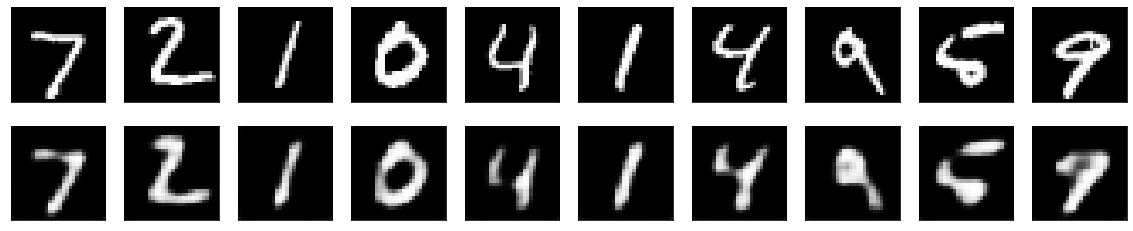

In [28]:
# plot
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # show origin images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # show autoencoded images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(noisy_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()